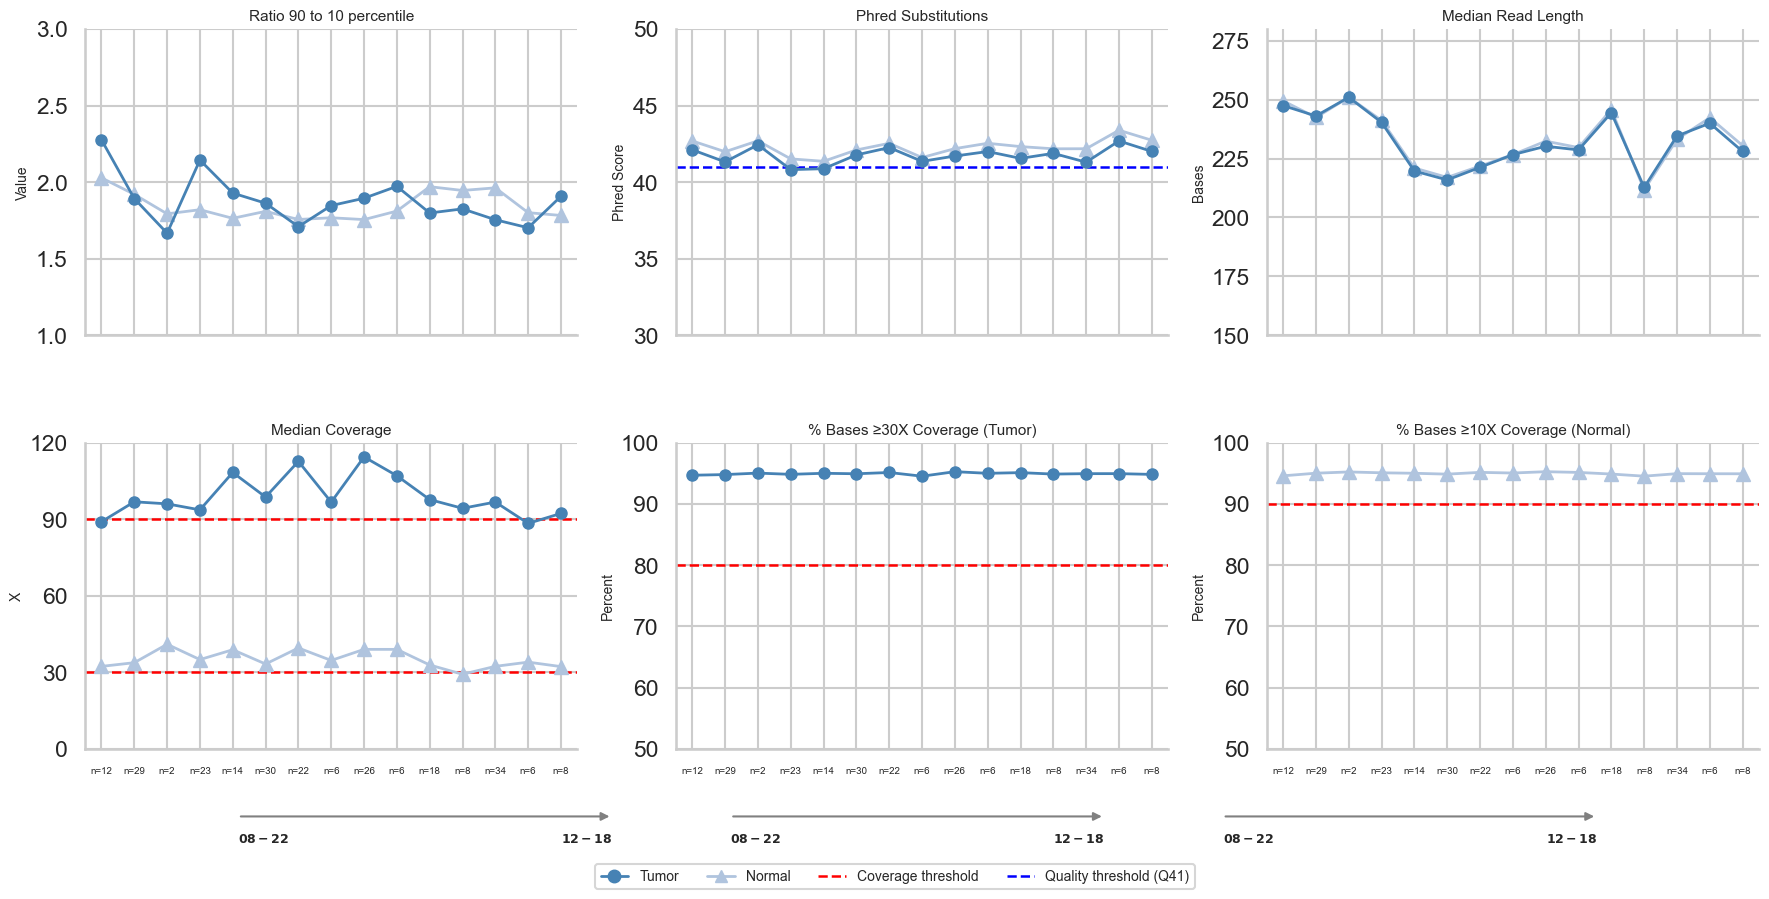

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import numpy as np
import pandas as pd

# --- Load data --- (DATA COMES FROM shiny_gatk_metrics_report.py (table tab and export))
# Skip first 2 data rows (AVERAGE and SUM summary rows)
df = pd.read_csv("table_overview_all_good_sets.csv", skiprows=[1, 2])

# Filter out summary rows and parse dates
df = df[~df["Date"].isin([np.nan, "Date", ""])].copy()
df = df[df["SampleType"].isin(["Tumor", "Normal"])].copy()

# Handle date format (Excel may have converted to DD/MM/YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True)

# Create coverage columns specific to sample type
df["PCT30X"] = np.where(df["SampleType"] == "Tumor", df["PCT_30X"], np.nan)
df["PCT10X"] = np.where(df["SampleType"] == "Normal", df["PCT_10X"], np.nan)

# --- Per-date sample counts ---
counts_per_date = df.groupby("Date").size()

# --- Aggregate: mean per Date & SampleType ---
summary = df.groupby(["Date", "SampleType"], as_index=False).agg(
    R90_10_mean=("ratio_90_to_10percentile", "mean"),
    Phred_mean=("Phred_Substitutions", "mean"),
    RL_mean=("median_read_length", "mean"),
    MedCov_mean=("MEDIAN_COVERAGE", "mean"),
    PCT30X_mean=("PCT30X", "mean"),
    PCT10X_mean=("PCT10X", "mean"),
)

# Add sample count for annotations
summary["SampleCount"] = summary["Date"].map(counts_per_date)

# Get sorted unique dates
sorted_dates = sorted(summary["Date"].dropna().unique())

# Create a mapping from date to evenly spaced x-position (0, 1, 2, ...)
date_to_x = {d: i for i, d in enumerate(sorted_dates)}
summary["X_pos"] = summary["Date"].map(date_to_x)

# --- Long format ---
plot_df = summary.melt(
    id_vars=["Date", "SampleType", "SampleCount", "X_pos"],
    value_vars=["R90_10_mean", "Phred_mean", "RL_mean", "MedCov_mean", "PCT30X_mean", "PCT10X_mean"],
    var_name="Metric", value_name="Value"
)

# Nicer labels
labels = {
    "R90_10_mean": "Ratio 90 to 10 percentile",
    "Phred_mean": "Phred Substitutions",
    "RL_mean": "Median Read Length",
    "MedCov_mean": "Median Coverage",
    "PCT30X_mean": "% Bases ≥30X Coverage (Tumor)",
    "PCT10X_mean": "% Bases ≥10X Coverage (Normal)",
}
plot_df["Metric"] = plot_df["Metric"].map(labels)

# Convert selected metrics to percentages (assumes fractions 0-1)
percent_metrics = {
    "% Bases ≥30X Coverage (Tumor)",
    "% Bases ≥10X Coverage (Normal)",
}
plot_df["Value_plot"] = plot_df.apply(
    lambda r: r["Value"] * 100 if r["Metric"] in percent_metrics else r["Value"],
    axis=1
)

# Per-metric axis + thresholds
settings = {
    "Ratio 90 to 10 percentile": {"ylim": (1.0, 3.0), "ylabel": "Value"},
    "Phred Substitutions": {"ylim": (30, 50), "ylabel": "Phred Score", "thresh": 41},
    "Median Read Length": {"ylim": (150, 280), "ylabel": "Bases"},
    "Median Coverage": {"ylim": (0, 120), "ylabel": "X", "cuts": [(90, "red"), (30, "red")], "yticks": [0, 30, 60, 90, 120]},
    "% Bases ≥30X Coverage (Tumor)": {"ylim": (50, 100), "ylabel": "Percent", "cuts": [(80, "red")]},
    "% Bases ≥10X Coverage (Normal)": {"ylim": (50, 100), "ylabel": "Percent", "cuts": [(90, "red")]},
}

# Build x-axis tick labels: all just n=X
tick_labels = []
start_date_str = sorted_dates[0].strftime('%m-%d')
end_date_str = sorted_dates[-1].strftime('%m-%d')

for i, d in enumerate(sorted_dates):
    count = int(counts_per_date.get(d, 0))
    tick_labels.append(f"n={count}")

plt.close("all")
sns.set(style="whitegrid", context="talk")

# Get unique metrics for faceting - horizontal layout: 2 rows x 3 columns
metric_order = list(labels.values())
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex=True)
axes = axes.flatten()

colors = {"Tumor": "steelblue", "Normal": "lightsteelblue"}
markers = {"Tumor": "o", "Normal": "^"}

for idx, metric_label in enumerate(metric_order):
    ax = axes[idx]
    metric_data = plot_df[plot_df["Metric"] == metric_label]
    
    for sample_type in ["Normal", "Tumor"]:  # Draw Normal first (behind)
        d = metric_data[metric_data["SampleType"] == sample_type].sort_values("X_pos")
        if d.empty:
            continue
        ax.plot(
            d["X_pos"], d["Value_plot"],
            marker=markers[sample_type],
            markersize=8 if sample_type == "Tumor" else 10,
            linewidth=2,
            color=colors[sample_type],
            label=sample_type,
            zorder=3 if sample_type == "Tumor" else 2
        )
    
    # Set x-axis ticks evenly spaced
    ax.set_xlim(-0.5, len(sorted_dates) - 0.5)
    ax.set_xticks(range(len(sorted_dates)))
    ax.set_xticklabels(tick_labels, fontsize=7)
    ax.tick_params(axis="x", rotation=0)
    
    # Apply per-panel settings
    cfg = settings.get(metric_label, {})
    if "ylim" in cfg:
        ax.set_ylim(*cfg["ylim"])
    if "yticks" in cfg:
        ax.set_yticks(cfg["yticks"])
    ax.set_ylabel(cfg.get("ylabel", "Value"), fontsize=10)
    ax.set_title(metric_label, fontsize=11)
    
    # Draw thresholds
    if "cuts" in cfg:
        for val, color in cfg["cuts"]:
            ax.axhline(val, linestyle="--", linewidth=1.8, color=color, zorder=1)
    if "thresh" in cfg:
        ax.axhline(cfg["thresh"], linestyle="--", linewidth=1.8, color="blue", zorder=1)

# Add timeline arrow below bottom row plots (indices 3, 4, 5)
for ax in axes[3:]:
    ax.set_xlabel("")
    
    # Get axis position in figure coordinates
    bbox = ax.get_position()
    
    # Add timeline arrow closer to the x-axis
    arrow_y = bbox.y0 - 0.045
    arrow_start_x = bbox.x0 + 0.01
    arrow_end_x = bbox.x1 - 0.01
    
    # Draw arrow
    arrow = FancyArrowPatch(
        (arrow_start_x, arrow_y), (arrow_end_x, arrow_y),
        transform=fig.transFigure,
        arrowstyle='-|>',
        mutation_scale=12,
        linewidth=1.5,
        color='gray',
        clip_on=False
    )
    fig.patches.append(arrow)
    
    # Add start date (bold) at the left
    fig.text(arrow_start_x, arrow_y - 0.018, f"$\\bf{{{start_date_str}}}$", 
             ha='left', va='top', fontsize=9, fontweight='bold')
    
    # Add end date (bold) at the right
    fig.text(arrow_end_x, arrow_y - 0.018, f"$\\bf{{{end_date_str}}}$", 
             ha='right', va='top', fontsize=9, fontweight='bold')

# Build legend
handles = [
    Line2D([0], [0], color="steelblue", marker="o", lw=2.0, label="Tumor"),
    Line2D([0], [0], color="lightsteelblue", marker="^", lw=2.0, label="Normal"),
    Line2D([0], [0], linestyle="--", color="red", lw=1.8, label="Coverage threshold"),
    Line2D([0], [0], linestyle="--", color="blue", lw=1.8, label="Quality threshold (Q41)"),
]

fig.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=4,
    frameon=True,
    fontsize=10,
)

sns.despine()
plt.subplots_adjust(left=0.05, right=0.98, bottom=0.14, top=0.94, wspace=0.2, hspace=0.35)
plt.show()

In [9]:
fig.savefig("multi_metric_plot.png", dpi=300, bbox_inches="tight")